# Looking at how we can fit discrete models with variational inference 

This code mainly looks at simpler problem of finding a discrete Q which approximates a fixed, known discrete P by minimizing KL divergence.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from multiple_subject_vae_2 import BernoulliCondDistribution
from multiple_subject_vae_2 import CondSpikeSlabDistribution
from multiple_subject_vae_2 import CondGaussianDistribution
from multiple_subject_vae_2 import ConstantRealFcn
from multiple_subject_vae_2 import ConstantLowerBoundedFcn
from multiple_subject_vae_2 import ConstantLowerUpperBoundedFcn
from multiple_subject_vae_2 import LogBumpFcn
from multiple_subject_vae_2 import LogProbTanhFcn
from multiple_subject_vae_2 import make_bernoulli_vi_debug_figure
from multiple_subject_vae_2 import visualize_bernoulli_distribution
from multiple_subject_vae_2 import visualize_spike_slab_distribution

## Generate neuron properties for all of the simulations below

In [3]:
# Properties of neurons we condition on 
neuron_props = torch.zeros(2000, 2).uniform_()

## Here we find a q distribution which approximates a fixed p by minimizing kl divergencve

In [107]:
# Basic Bernoulli distributions
#p = BernoulliCondDistribution(ConstantLowerUpperBoundedFcn(1, lower_bound=-10.0, upper_bound=0.0))
#q = BernoulliCondDistribution(ConstantLowerUpperBoundedFcn(1, lower_bound=-10.0, upper_bound=0.0))
#p.log_prob_fcn.v.data = torch.tensor([2.0])

# Bernoulli distributions which change probabilities condition on neuron properties
p_log_prob_fcn = LogBumpFcn(2)
p_log_prob_fcn.log_gain_vl.v.data = torch.tensor([1000.0])
p_log_prob_fcn.ctr.data = torch.tensor([.25, .25])
p_log_prob_fcn.ctr_stds.v.data = torch.tensor([-4.0, -4])
p = BernoulliCondDistribution(p_log_prob_fcn)

q_log_prob_fcn = LogBumpFcn(2, f_type='exp')
q_log_prob_fcn.ctr_stds.v.data = torch.tensor([-2, -2.0])
q_log_prob_fcn.log_gain_vl.lower_bound = np.log(.002)
q_log_prob_fcn.log_gain_vl.v.data = torch.tensor(100.0)

q = BernoulliCondDistribution(q_log_prob_fcn)

it: 0, o: -121211.305
it: 200, o: -2074.3906
it: 400, o: -884.865
it: 600, o: -745.51855
it: 800, o: -124.027855
it: 1000, o: -272.31458
it: 1200, o: -326.78323
it: 1400, o: -364.3679
it: 1600, o: -91.06883
it: 1800, o: -66.24042


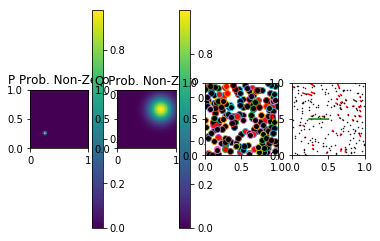

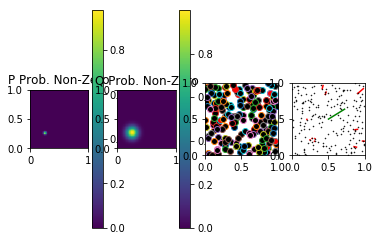

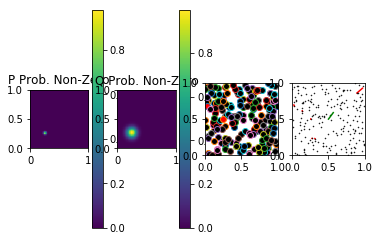

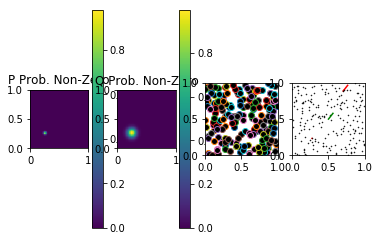

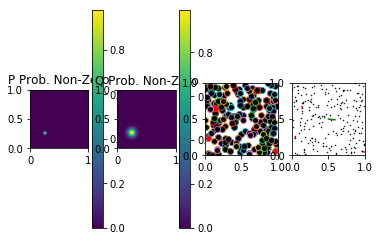

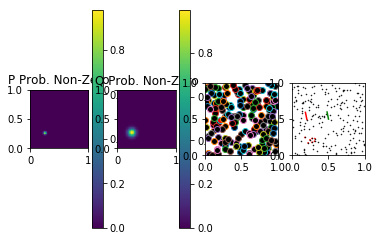

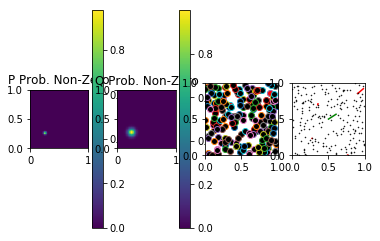

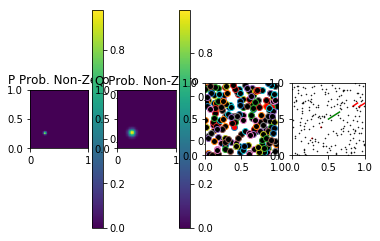

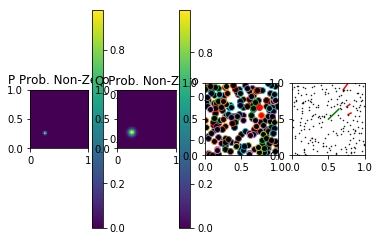

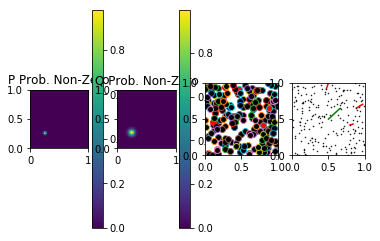

In [108]:
## Fit q to p with variational inference

#params = q.parameters()

enforce_borders = False
lower_border = .05
upper_border = .95

params = [{'params': q.log_prob_fcn.ctr_stds.parameters(), 'lr': .01},
          {'params': q.log_prob_fcn.log_gain_vl.parameters(), 'lr': .01},
          {'params': q.log_prob_fcn.ctr, 'lr': .01}]

optim = torch.optim.Adam(params=params, lr=.01)

n_its = 2000
batch_size = 2000
o_vls = np.zeros(n_its)
sum_l = np.zeros(n_its)
l_log = [None]*n_its

c_i = torch.zeros(1)
for i in range(n_its):
    optim.zero_grad()
    
    with torch.no_grad():
        smp_inds = np.random.choice(neuron_props.shape[0], batch_size)
        smp_i = q.sample(neuron_props[smp_inds,:])
        l = q.log_prob(neuron_props[smp_inds,:], smp_i) - p.log_prob(neuron_props[smp_inds,:], smp_i)
        sum_l[i] = torch.sum(l).numpy()
        c_i = torch.mean(l)
        l_log[i] = l.detach().numpy()
    
    o = torch.sum((l- c_i)*q.log_prob(neuron_props[smp_inds,:], smp_i))
    
    o.backward()
    
    optim.step();
    
    if enforce_borders:
        with torch.no_grad():
            cur_c = q.log_prob_fcn.ctr.data.detach().numpy()
            cur_c[0] = np.min([np.max([cur_c[0], lower_border]), upper_border])
            cur_c[1] = np.min([np.max([cur_c[0], lower_border]), upper_border])
            q.log_prob_fcn.ctr.data = torch.from_numpy(cur_c)
    
    record_o = o.detach().numpy()
    if i % 200 == 0:
        print('it: ' + str(i) + ', o: ' + str(record_o))
        j_range = np.arange(0, neuron_props.shape[0], 10)
        l_d = l.detach().numpy()
        smp_i_plot = smp_i.detach().numpy()
        
        grads = np.zeros([len(j_range), 2])
        for j_i, j in enumerate(j_range):
            optim.zero_grad()
            with torch.no_grad():
                l_j = (q.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].unsqueeze(0)) - 
                        p.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].unsqueeze(0)))
            
            o_j = l_j*q.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].reshape([1]))
            o_j.backward()
            grads[j_i,:] = q.log_prob_fcn.ctr.grad.data.numpy().copy()
        
        make_bernoulli_vi_debug_figure(q, p, smp_x=neuron_props[j_range], smp_y=smp_i_plot[j_range],
                                       grads=grads)

    o_vls[i] = record_o
    

## Generate data from one spike and slab distribution and fit another with maximum likelihood

We use the same ground truth data and distribution we used with the variational inference approach

In [ ]:
# Ground truth distribution 
spike_log_prob_fcn = LogBumpFcn(2)
spike_log_prob_fcn.ctr_stds.v.data = torch.tensor([-2.0, -2.0])
spike_dist = BernoulliCondDistribution(log_prob_fcn=spike_log_prob_fcn)



slab_mn_fcn = ConstantRealFcn(n_dims=1)
slab_mn_fcn.vl.data = torch.tensor([5.0])
slab_std_fcn = ConstantLowerBoundedFcn(n_dims=1, lower_bound=.05)
slab_std_fcn.log_vl.data = torch.tensor([0.0])
slab_dist = CondGaussianDistribution(slab_mn_fcn, slab_std_fcn)

spike_slab_dist = CondSpikeSlabDistribution(spike_dist=spike_dist, slab_dist=slab_dist, d=1)

In [ ]:
# Get samples for true distribution
with torch.no_grad():
    support, nz_vls = spike_slab_dist.sample(neuron_props)

    y = torch.zeros(len(support))
    y[support] = nz_vls
    y = y.unsqueeze(1)

In [ ]:
# Fitted distribution 

f_spike_log_prob_fcn = LogBumpFcn(2)
f_spike_dist = BernoulliCondDistribution(f_spike_log_prob_fcn)

f_slab_mn_fcn = ConstantRealFcn(n_dims=1)
f_slab_std_fcn = ConstantLowerBoundedFcn(n_dims=1, lower_bound=.05)
f_slab_std_fcn.log_vl.data = torch.tensor([5.0])
f_slab_dist = CondGaussianDistribution(f_slab_mn_fcn, f_slab_std_fcn)

f_spike_slab_dist = CondSpikeSlabDistribution(spike_dist=f_spike_dist, slab_dist=f_slab_dist,
                                              d=1)


In [ ]:
## Fit spike slab distribution with maximum likelihood

params = f_spike_slab_dist.parameters()
optim = torch.optim.Adam(params=params, lr=.01)

for i in range(2000): 
    optim.zero_grad()
    
    nll = -1*torch.sum(f_spike_slab_dist.log_prob(neuron_props, y))
    nll.backward()
    optim.step()
    if i % 200 == 0:
        print('i:' + str(i) + ', nll: ' +  str(nll.detach()))

In [ ]:
# Visualize True distribution
visualize_spike_slab_distribution(spike_slab_dist, smp_x=neuron_props, smp_y=y.squeeze())

In [ ]:
# Visualize Fit distribution
visualize_spike_slab_distribution(f_spike_slab_dist)